the wave equation reads as
\begin{equation*}
u_{t t}=u_{x x} .
\end{equation*}

The function $u(t, x)=\frac{1}{2} \sin (\pi x) \cos (\pi t)+\frac{1}{3} \sin (3 \pi x) \sin (3 \pi t)$ solves this equation and satisfies the following initial and homogeneous Dirichlet boundary conditions
\begin{equation*}
\begin{aligned}
& u(0, x)=u^0(x):=\frac{1}{2} \sin (\pi x), \\
& u_t(0, x)=v^0(x):=\pi \sin (3 \pi x) \\
& u(t, 0)=u(t, 1)=0
\end{aligned}
\end{equation*}


In [95]:
from dataclasses import dataclass, field

from jaxtyping import (
    Float,
)
from gpjax.typing import (
    Array,
    ScalarFloat,
)
import jax.numpy as jnp
import jax.random as jr
import jax.numpy as jnp
import gpjax as gpx
from jax import jit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from jax import config

import tensorflow_probability.substrates.jax.bijectors as tfb
from gpjax.base import param_field
config.update("jax_enable_x64", True)

In [96]:
from simple_pytree import static_field


@dataclass 
class periodicKernel(gpx.kernels.AbstractKernel):
    kernel: gpx.kernels.AbstractKernel = field(
        default_factory=lambda: gpx.kernels.RBF(active_dims=[0,1])
    )
    kernel = gpx.kernels.RBF(active_dims=[0,1])
    # add another parameter to the kernel
    
    k: ScalarFloat = param_field(jnp.array(np.pi*2), bijector=tfb.Softplus(), trainable = True)
    k_0: ScalarFloat = static_field(jnp.array(np.pi*2))
    #softclif

    def __call__(
        self, 
        X: Float[Array, "1 D"], 
        Xp: Float[Array, "1 D"]
        ) -> Float[Array, "1"]:
        # standard RBF-SE kernel is x and x' are on the same output, otherwise returns 0
        # return self.kernel(X, Xp)
        return self.kernel(X, Xp) * jnp.cos(self.k * (X[0]-Xp[0]))

In [97]:
# some plotting defaults
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
key = jr.PRNGKey(400)
key, subkey = jr.split(key)

In [98]:
key,subkey

(Array([ 774275716, 2700357239], dtype=uint32),
 Array([1659077811, 2987792938], dtype=uint32))

In [99]:
def fn_u(t,x):
    return 1/2*np.sin(np.pi*x)*np.cos(np.pi*t) + 1/3*np.sin(3*np.pi*x)*np.sin(3*np.pi*t)

In [100]:
def fn_v(t,x):
    #return the time derivative of the wavefunction
    return 1/2*np.pi*np.sin(np.pi*x)*np.sin(np.pi*t) + 1/3*3*np.pi*np.sin(3*np.pi*x)*np.cos(3*np.pi*t)

In [101]:
def plot_u_v(data_ground_truth, data_sample = None, data_prediction = None):
    fig, ax = plt.subplots(2,4,figsize=(30,10))

    t = jnp.array([0,0.38,0.76,1.14])

    for i, t in enumerate(t):
        ax[0,i].plot(data_ground_truth[:,i,0], data_ground_truth[:,i,1])
        ax[0,i].set_xlim(0,1)
        ax[0,i].set_ylim(-1,1)
        ax[1,i].plot(data_ground_truth[:,i,0], data_ground_truth[:,i,2])
        ax[1,i].set_xlim(0,1)
        ax[1,i].set_ylim(-5,5)
        ax[0,i].set_title('t = {}'.format(t))
        ax[0,i].set_xlabel('x')
        ax[0,i].set_ylabel('u')
        ax[1,i].set_xlabel('x')
        ax[1,i].set_ylabel('v')

    if data_sample is not None:
        ax[0,0].scatter(data_sample[:,0,0], data_sample[:,0,1], marker = 'x', color = 'r')
        ax[1,0].scatter(data_sample[:,0,0], data_sample[:,0,2], marker = 'x', color = 'r')

    if data_prediction is not None:
        
        # Unpack the data
        x = data_prediction[:,0]
        u = data_prediction[:,1]
        v = data_prediction[:,2]

        print (data_prediction.shape)
        print (u)
        
        ax[0,0].plot(x, u, "r--", label="Predictive mean")
        ax[1,0].plot(x, v, "r--", label="Predictive mean")
        # ax[0,0].fill_between(
        #     x,
        #     predictive_mean - 1.96 * predictive_std,
        #     predictive_mean + 1.96 * predictive_std,
        #     color="C0",
        #     alpha=0.2,
        #     label="95% CI",
        # )
    plt.show()

(1001, 4, 3)


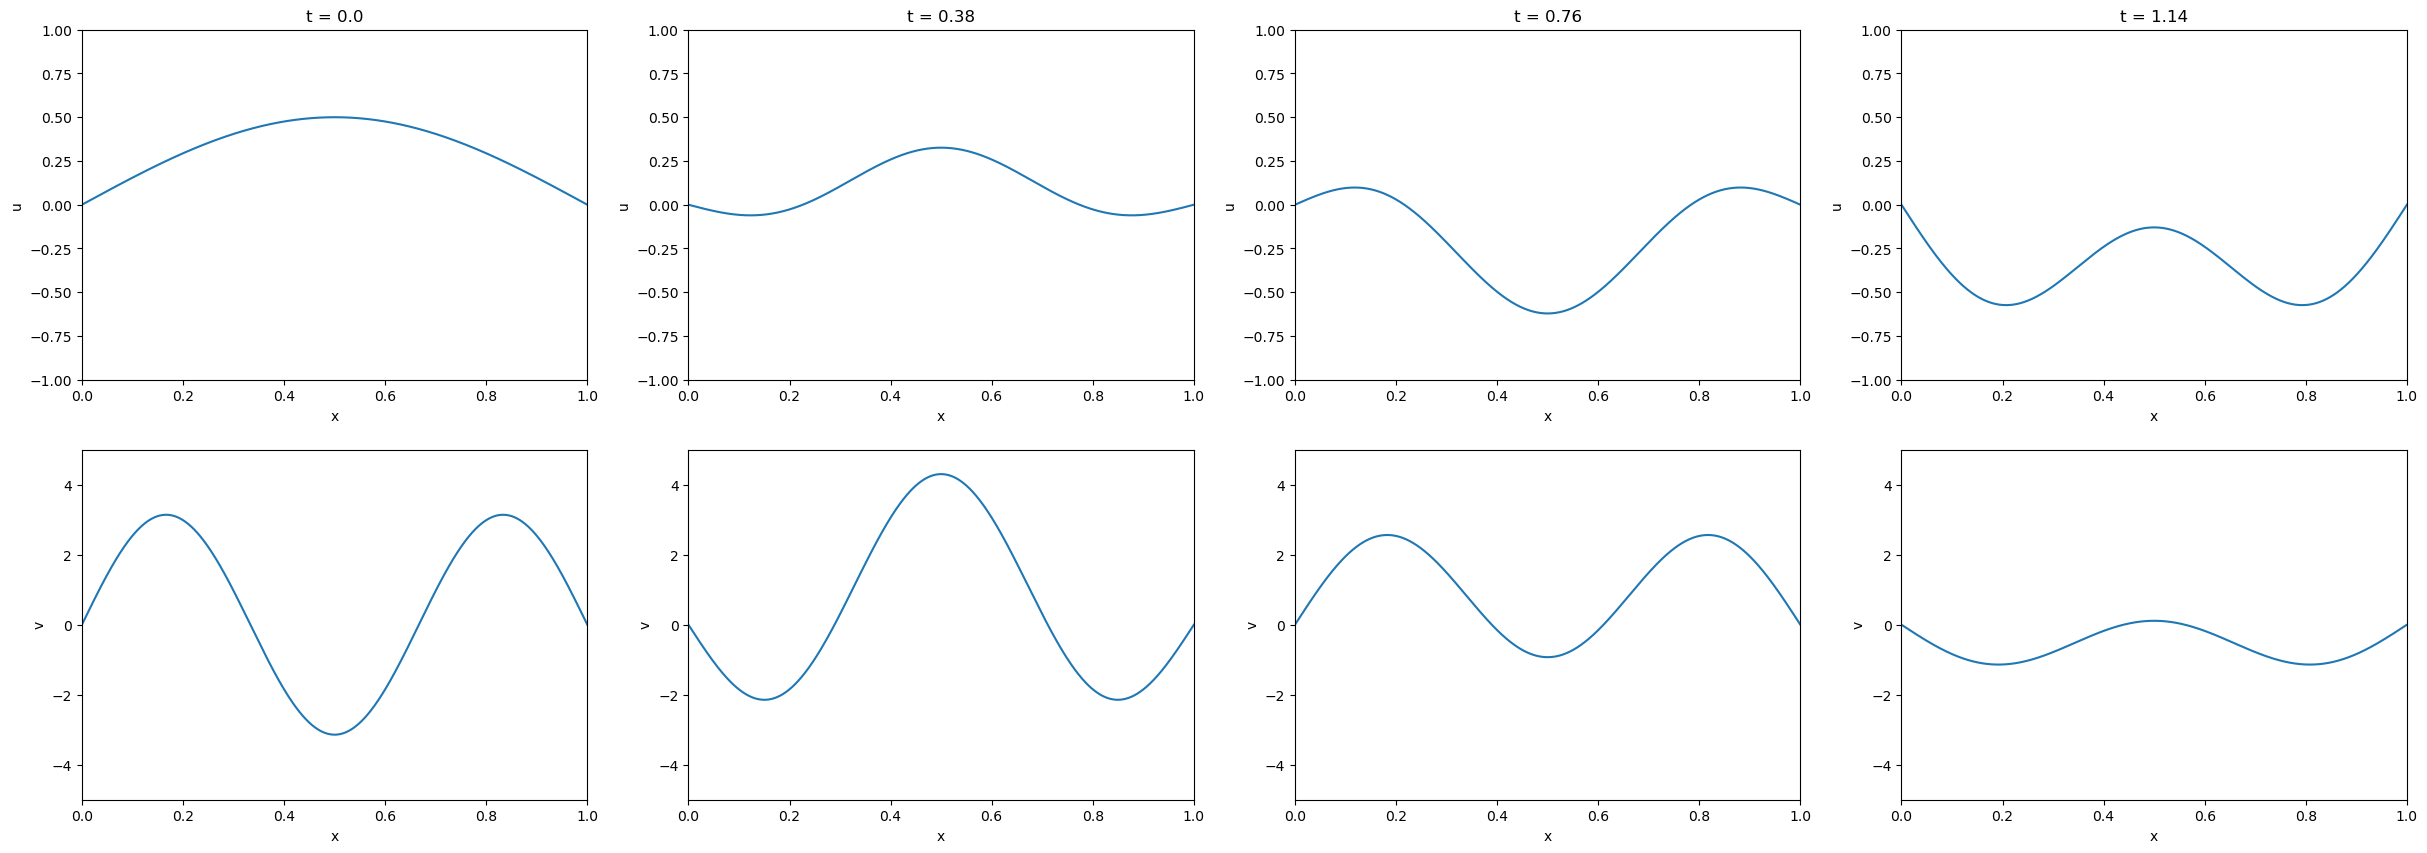

In [102]:
# create x as 100 points between 0 and 1, with equally spaced timesteps
x = jnp.linspace(0,1,1001)
t = jnp.array([0,0.38,0.76,1.14])
x_mesh, t_mesh = jnp.meshgrid(x,t) 
data_ground_truth = jnp.array([x_mesh, fn_u(t_mesh,x_mesh), fn_v(t_mesh,x_mesh)]).T
print (data_ground_truth.shape)
plot_u_v(data_ground_truth)

In [103]:
# number of sample points
N = 25

In [104]:
noise = 0.1

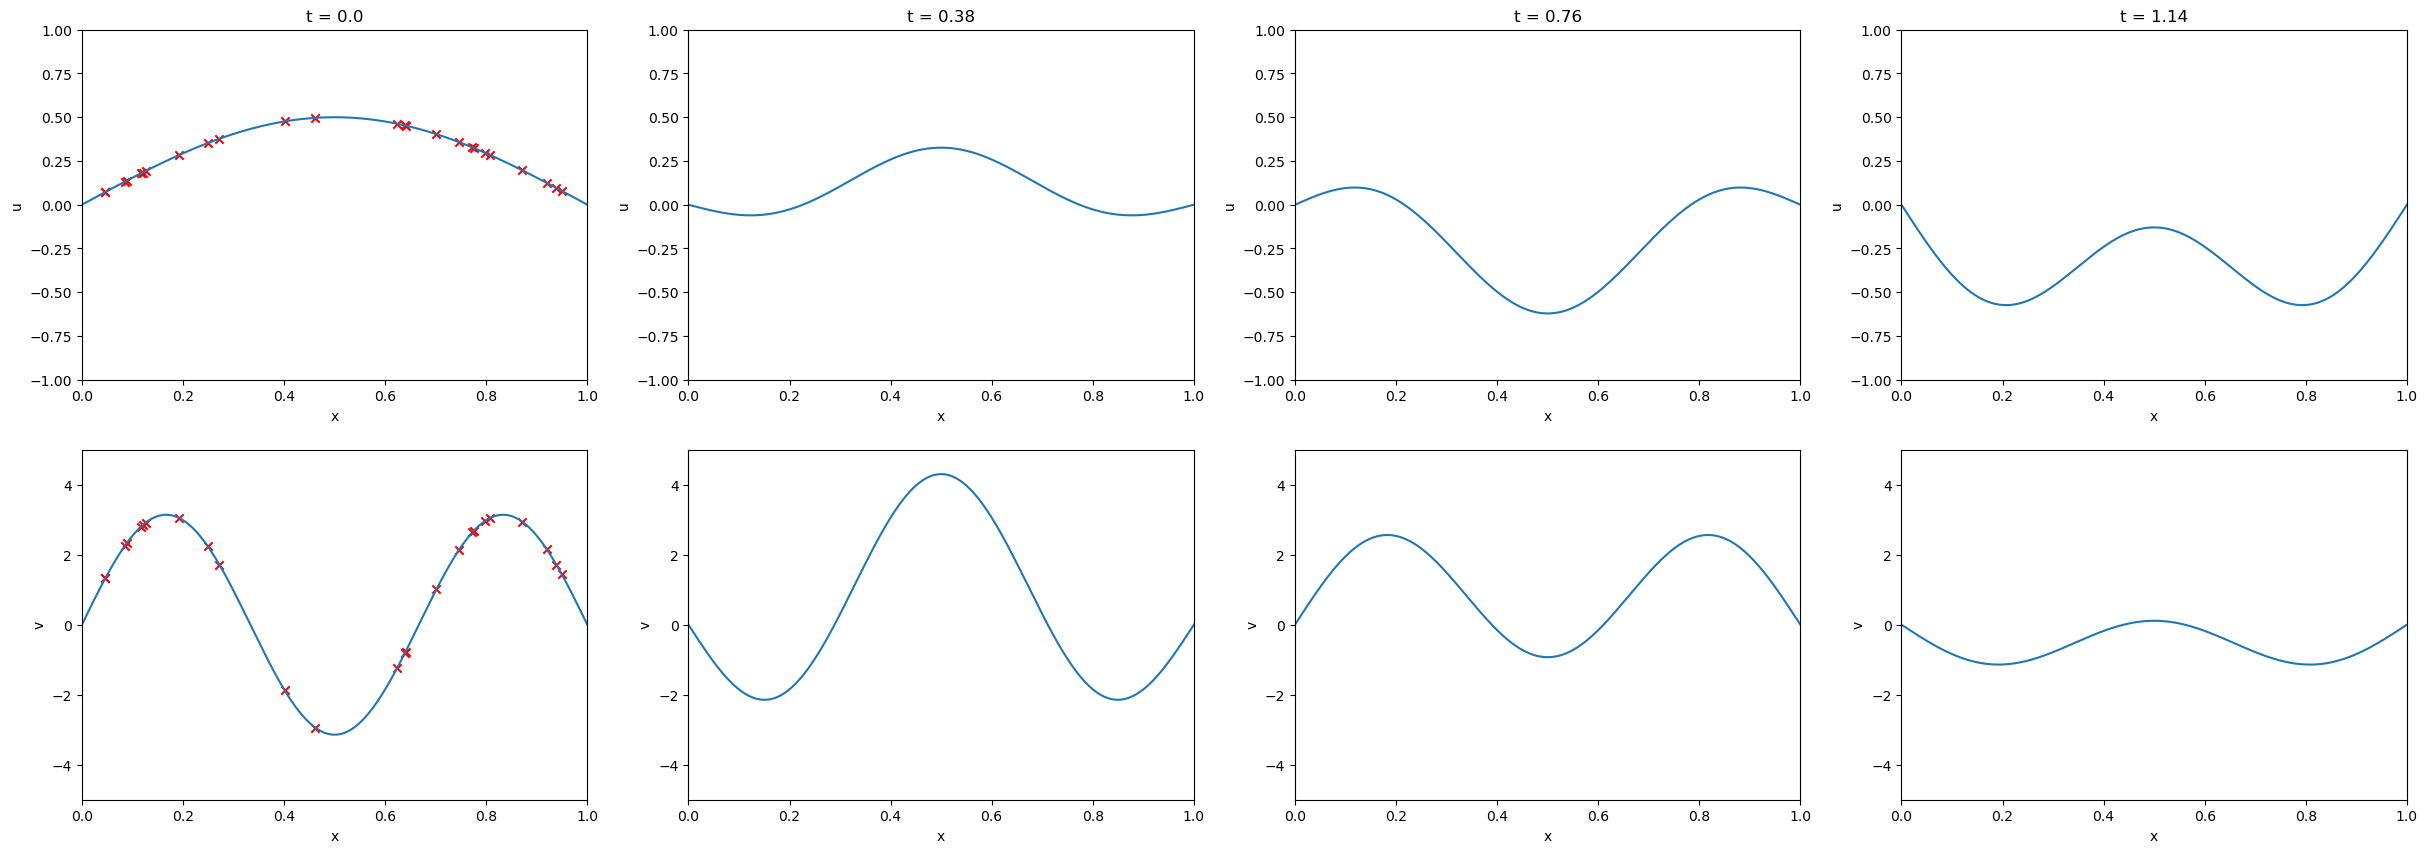

In [105]:
# create a random sample of N points from 0 to 1
x_sample = jr.uniform(subkey, (N,), minval=0, maxval=1)
x_sample = jnp.sort(x_sample)

t_sample = jnp.array([0]) 
x_sample_mesh, t_sample_mesh = jnp.meshgrid(x_sample,t_sample)
data_sample = jnp.array([x_sample_mesh, fn_u(t_sample_mesh,x_sample_mesh), fn_v(t_sample_mesh,x_sample_mesh)]).T
plot_u_v(data_ground_truth, data_sample)

In [106]:
#Use Gaussian Process the predict the wavefunction at t = 0 using the data_sample
X_train = jnp.array(data_sample[:,0,0]).reshape(-1,1)
# reshape y into only 2 columns
y_train = jnp.vstack([data_sample[:,0,1], data_sample[:,0,2]]).T.reshape(-1,2)

# add some noise to y
y_train += noise * jnp.std(y_train) * jr.normal(subkey, y_train.shape)

X_test = jnp.array(data_ground_truth[:,0,0]).reshape(-1,1)

y_test = jnp.vstack([data_ground_truth[:,0,1], data_ground_truth[:,0,2]]).T.reshape(-1,2)

In [107]:
# Change vectors x -> X = (x,z), and vectors y -> Y = (y,z) via the artificial z label
def label_position(data):
    # introduce alternating z label
    n_points = len(data[0])
    label = jnp.tile(jnp.array([0.0, 1.0]), n_points)
    return jnp.vstack((jnp.repeat(data, repeats=2, axis=1), label)).T


# change vectors y -> Y by reshaping the velocity measurements
def stack_velocity(data):
    return data.T.flatten().reshape(-1, 1)


def dataset_3d(pos, vel):
    return gpx.Dataset(label_position(pos), stack_velocity(vel))




In [108]:
dataset_train = dataset_3d(X_train.T, y_train.T)
dataset_ground_truth = dataset_3d(X_test.T, y_test.T) 

In [109]:
# label and place the training data into a Dataset object to be used by GPJax
D_u = gpx.Dataset(X_train.reshape(-1,1),y_train[:,0].reshape(-1,1))
D_v = gpx.Dataset(X_train.reshape(-1,1),y_train[:,1].reshape(-1,1))

In [110]:
# define the mean and kernel functions
mean = gpx.mean_functions.Zero()
# kernel = gpx.kernels.RBF()
kernel = periodicKernel()
prior = gpx.gps.Prior(mean_function = mean, kernel = kernel)

# Construct GP likelihood
likelihood = gpx.likelihoods.Gaussian(num_datapoints = N)

# Construct the posterior
posterior = prior * likelihood

# define the log marginal likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)

In [ ]:



posterior 

In [111]:
opt_posterior_u, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=D_u,
)

# obtax

# reset the model

opt_posterior_v, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=D_v,
)

print (history)

Initial loss is 27.069688345038756
Optimization was successful
Final loss is -8.259158766149463 after 39 iterations
Initial loss is 40.32883963742198
Optimization was successful
Final loss is -11.393800682155323 after 75 iterations
[ 40.32883964 -11.39380068]


In [121]:
opt_posterior_u.prior.kernel

periodicKernel(compute_engine=DenseKernelComputation(), active_dims=None, name='AbstractKernel', kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=[0, 1], name='RBF', lengthscale=Array(512.4252, dtype=float32), variance=Array(0.11384908, dtype=float32)), k=Array(3.44606432, dtype=float64))

In [112]:
latent_u = opt_posterior_u.predict(X_test, train_data=D_u)
predictive_mean_u = latent_u.mean()
predictive_std_u = latent_u.stddev()

latent_v = opt_posterior_v.predict(X_test, train_data=D_v)
predictive_mean_v = latent_v.mean()
predictive_std_v = latent_v.stddev()



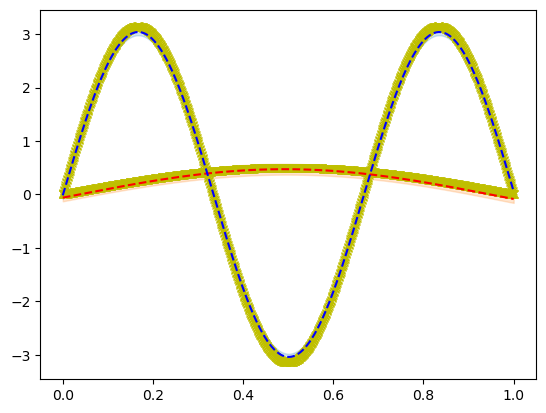

In [113]:
# plot predicted mean
plt.plot(X_test, y_test, "yx", label="Ground Truth")
plt.plot(X_test, predictive_mean_u, "r--", label="Predictive mean")
plt.plot(X_test, predictive_mean_v, "b--", label="Predictive mean")
plt.fill_between(
    X_test.flatten(),
    predictive_mean_u - 1.96 * predictive_std_u,
    predictive_mean_u + 1.96 * predictive_std_u,
    color="C1",
    alpha=0.2,
    label="95% CI",
)
plt.fill_between(
    X_test.flatten(),
    predictive_mean_v - 1.96 * predictive_std_v,
    predictive_mean_v + 1.96 * predictive_std_v,
    color="C0",
    alpha=0.2,
    label="95% CI",
)

plt.show()



In [114]:
@dataclass
class VelocityKernel(gpx.kernels.AbstractKernel):
    kernel0: gpx.kernels.AbstractKernel = field(
        default_factory=lambda: gpx.kernels.RBF(active_dims=[0,1])
    )
    kernel1: gpx.kernels.AbstractKernel = field(
        default_factory=lambda: gpx.kernels.RBF(active_dims=[0,1])
    )
    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        # standard RBF-SE kernel is x and x' are on the same output, otherwise returns 0

        z = jnp.array(X[1], dtype=int)
        zp = jnp.array(Xp[1], dtype=int)

        # achieve the correct value via 'switches' that are either 1 or 0
        k0_switch = ((z + 1) % 2) * ((zp + 1) % 2)
        k1_switch = z * zp

        return k0_switch * self.kernel0(X, Xp) + k1_switch * self.kernel1(X, Xp)

In [115]:
# define the mean and kernel functions
mean = gpx.mean_functions.Zero()
kernel = gpx.kernels.RBF()
kernel = VelocityKernel()
prior = gpx.gps.Prior(mean_function = mean, kernel = kernel)

# Construct GP likelihood
likelihood = gpx.likelihoods.Gaussian(num_datapoints = N)

# Construct the posterior
posterior = prior * likelihood

# define the log marginal likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)

Initial loss is 84.51231356309746
Optimization was successful
Final loss is 80.48790565684375 after 47 iterations


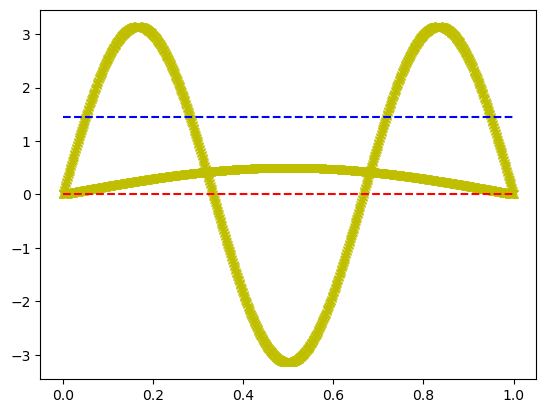

In [116]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=dataset_train,
)

latent = opt_posterior.predict(dataset_ground_truth.X, train_data=dataset_train)
predictive_mean = latent.mean()
predictive_std = latent.stddev()

dataset_prediction = dataset_3d(X_test.T, predictive_mean.T)

# plot true mean
plt.plot(dataset_ground_truth.X[:,0][0::2],dataset_ground_truth.y[:,0][0::2], "yx", label="Ground Truth")
plt.plot(dataset_ground_truth.X[:,0][0::2],dataset_ground_truth.y[:,0][1::2], "yx", label="Ground Truth")
#plot predicted mean
plt.plot(X_test, predictive_mean[0::2], "r--", label="Predictive mean")
plt.plot(X_test, predictive_mean[1::2], "b--", label="Predictive mean")

plt.show()



\begin{align}
\begin{aligned}
u^n & =u^{n-1 / 2}+\frac{1}{2} \Delta t v^{n-1 / 2} \\
v^n & =v^{n-1 / 2}+\frac{1}{2} \Delta t \frac{d^2}{d x^2} u^{n-1 / 2}
\end{aligned}
\end{align}

In [117]:
@dataclass
class BlockKernel(gpx.kernels.AbstractKernel):
    kerneluu: gpx.kernels.AbstractKernel = field(
        default_factory=lambda: periodicKernel(active_dims=[0, 1])
    )
    # kerneluv: gpx.kernels.AbstractKernel = field(
    #     default_factory=lambda: gpx.kernels.RBF(active_dims=[0, 1])
    # )
    # kernelvu: gpx.kernels.AbstractKernel = field(
    #     default_factory=lambda: gpx.kernels.RBF(active_dims=[0, 1])
    # )
    kernelvv: gpx.kernels.AbstractKernel = field(
        default_factory=lambda: periodicKernel(active_dims=[0, 1])
    )
    

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        # compute the kernel matrix as a block matrix
        z = jnp.array(X[1], dtype=int)
        zp = jnp.array(Xp[1], dtype=int)

        switchuu = ((z + 1) % 2) * ((zp + 1) % 2)
        switchuv = ((z + 1) % 2) * (zp)
        switchvu = (z) * ((zp + 1) % 2)
        switchvv = (z) * (zp)

        return switchuu * self.kerneluu(X, Xp) + switchvv * self.kernelvv(X, Xp)
    
# define the mean and kernel functions
mean = gpx.mean_functions.Zero()
kernel = BlockKernel()
prior = gpx.gps.Prior(mean_function = mean, kernel = kernel)

# Construct GP likelihood
likelihood = gpx.likelihoods.Gaussian(num_datapoints = N)

# Construct the posterior
posterior = prior * likelihood

# define the log marginal likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)

Initial loss is 70.28187152419954
Optimization was successful
Final loss is -18.639366035890344 after 67 iterations


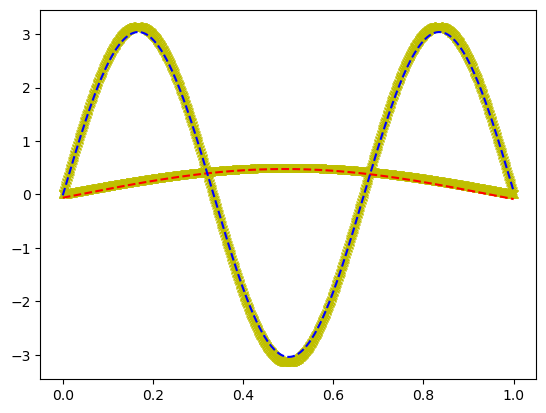

In [118]:
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=dataset_train,
)

latent = opt_posterior.predict(dataset_ground_truth.X, train_data=dataset_train)
predictive_mean = latent.mean()
predictive_std = latent.stddev()

dataset_prediction = dataset_3d(X_test.T, predictive_mean.T)

# plot true mean
plt.plot(dataset_ground_truth.X[:,0][0::2],dataset_ground_truth.y[:,0][0::2], "yx", label="Ground Truth")
plt.plot(dataset_ground_truth.X[:,0][0::2],dataset_ground_truth.y[:,0][1::2], "yx", label="Ground Truth")

#plot predicted mean
plt.plot(X_test, predictive_mean[0::2], "r--", label="Predictive mean")
plt.plot(X_test, predictive_mean[1::2], "b--", label="Predictive mean")

plt.show()

\begin{align}
k_{\text {per }}\left(x, x^{\prime}\right)=\sigma^2 \exp \left(-\frac{2 \sin ^2\left(\pi\left|x-x^{\prime}\right| / p\right)}{l^2}\right)
\end{align}